## Inverse Problem

This notebook is a simple example of how to solve an inverse problem using at3d. It assumes that we have run the 'SimulateRadiances' notebook and saved the result.

In [1]:
#imports
import at3d
import numpy as np
import xarray as xr
from collections import OrderedDict
import pylab as py
import warnings
np.random.seed(1)


### Load Measurements

Here we load the synthetic measurements and also all of the inputs to the solver. We will use several of these inputs to perform 'inverse crimes' whereby we fix some aspects of the problem perfectly as in the forward simulation. When using real world measurements no such short cuts are necessary.

* First, we have to look at the measurements and select a region of interest and define our `rte_grid`. 
* Then we have to model the sensor sub-pixel geometry.
* We need to analyze whether the grid and sensor geometry are consistent. The SpaceCarver is useful for this. If not then we may need to change resolution of `rte_grid` to match the resolution of the measurements etc.
* We need to decide how to represent the surface, which is currently fixed.
* We need to decide how to represent the atmosphere.
    * What scattering species are we modelling? What are their optical models? 
    * Which quantities will be unknowns and which are fixed?
    * What will be the abstract state that we will reconstruct? For this we need to set the mapping between the abstract state and the RTE solver.
* Now that we are organized we need to initialize our state vector of unknowns. The method for this initialization may itself be quite involved as starting nearer the answer is better. This typically goes hand in hand with the selection of any fixed variables.
* Lastly we perform the optimization.

In this tutorial we will reconstruct only the `extinction` and we will use forward quantities from the ground truth synthetic measurements for simplicity.

### Checks

In [2]:
sensors, solvers, rte_grid = at3d.util.load_forward_model('./SimulateRadiancesSmallRico.nc')

In [3]:
# Perform some cloud masking using a single fixed threshold based on the observation that 
# everywhere else will be very dark.
sensor_list = []
for sensor in sensors['MSPI']['sensor_list']:
    copied = sensor.copy(deep=True)
    weights = np.zeros(sensor.sizes['nrays'])
    ray_mask =np.zeros(sensor.sizes['nrays'], dtype=int)
    
    ray_mask_pixel = np.zeros(sensor.npixels.size, dtype=int)
    
    # I have not optimized this threshold whatsoever.
    # Feel free to experiment with the cloud mask threshold. 
    # You can compare the observations
    # with a visualization of the initial_state to evaluate the mask.
    # or look at at3d.space_carve.SpaceCarver.project
    ray_mask_pixel[np.where(sensor.I.data > 0*2e-3)] = 1
    copied['weights'] = ('nrays',sensor.I.data)
    copied['cloud_mask'] = ('nrays', ray_mask_pixel[sensor.pixel_index.data])
    sensor_list.append(copied)

space_carver = at3d.space_carve.SpaceCarver(rte_grid, bcflag=3)
carved_volume = space_carver.carve(sensor_list, agreement=(0.0, 1.0), linear_mode=False)

# remove cloud mask values at outer boundaries to prevent interaction with open boundary conditions.
carved_volume.mask[0] = carved_volume.mask[-1] =carved_volume.mask[:,0] =carved_volume.mask[:,-1] = 0.0
        

In [4]:

# make forward_sensors which will hold synthetic measurements from the evaluation of the forward model.
forward_sensors = sensors.make_forward_sensors()

# add an uncertainty model to the observations.
uncertainty = at3d.uncertainties.NullUncertainty('L2',1e8)#at3d.uncertainties.TandemStereoCamera('L2', camera_to_camera_calibration_uncertainty=0.0,
              #                                      absolute_calibration_uncertainty=0.0)#at3d.uncertainties.RadiometricUncertainty('L2',1e-5, 1e-3)
sensors.add_uncertainty_model('MSPI', uncertainty)

# prepare all of the static inputs to the solver just copy pasted from forward model
surfaces = OrderedDict()
numerical_parameters = OrderedDict()
sources = OrderedDict()
num_stokes = OrderedDict()
background_optical_scatterers = OrderedDict()
for key in forward_sensors.get_unique_solvers():
    surfaces[key] = solvers[key].surface
    numerical_params = solvers[key].numerical_params
    #numerical_params['num_mu_bins'] = 2
    #numerical_params['num_phi_bins'] = 4
    numerical_parameters[key] = numerical_params
    sources[key] = solvers[key].source
    num_stokes[key] = solvers[key]._nstokes
    background_optical_scatterers[key] = {'rayleigh': solvers[key].medium['rayleigh']}

mie_mono_tables = OrderedDict()
for wavelength in [.66]:
    mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=False
    )

optical_property_generator = at3d.medium.OpticalPropertyGenerator(
    'cloud', 
    mie_mono_tables,
    at3d.size_distribution.gamma,
    density_normalization='geometric_extinction',
    reff=np.linspace(.1,30.0,30),
    veff=np.linspace(0.03,0.2,9),
)

In [5]:
# set the generator for the unknown scatterer using ground truth optical properties
# and unknown extinction.
# GridToOpticalProperties holds the fixed optical properties and forms a full set of optical properties
# when it is called with extinction as the argument.

optical_properties = solvers[0.66].medium['cloud'].copy(deep=True)
optical_properties = optical_properties.drop_vars('extinction')

true_geo_extinct = 3.0*solvers[0.66].medium['cloud'].density.data/(2.0*997.0* solvers[0.66].medium['cloud'].reff.data*1e-6)


%matplotlib inline
def plot(optimizer):
    py.figure()
    fig, axs = py.subplots(1, 2)
    axs[0].plot(solvers_reconstruct[0.66].medium['cloud'].density.data.ravel(), 
            true_geo_extinct.ravel(),'x')
    axs[0].plot([0,130],[0,130])
    axs[1].plot(solvers_reconstruct[0.66].medium['cloud'].reff.data.ravel(), 
            solvers[0.66].medium['cloud'].reff.data.ravel(),'x')
    axs[1].plot([0,30],[0,30])
    axs[1].axvline(x = np.nanmean(solvers[0.66].medium['cloud'].reff.data.ravel()), color = 'r', linestyle='--')
    py.show()
    return {'None': None}
callback = at3d.callback.CallbackFn(plot)


In [6]:
solvers_reconstruct = at3d.containers.SolversDict()

# We are using the ground_truth rte_grid.
grid_to_optical_properties = at3d.medium.MicrophysicsGridToOpticalProperties(
    rte_grid, optical_property_generator, optical_properties
)
def get_loss(reff_diff):
    # UnknownScatterers is a container for all of the unknown variables.
    # Each unknown_scatterer also records the transforms from the abstract state vector
    # to the gridded data in physical coordinates.
    unknown_scatterers = at3d.containers.UnknownScatterers(
        at3d.medium.UnknownScatterer(grid_to_optical_properties,
        density=(None, at3d.transforms.StateToGridMask(mask=carved_volume.mask.data)),
        reff=(None, at3d.transforms.StateToGridProfile(mask=carved_volume.mask.data)))
    )
    # now we form state_gen which updates the solvers with an input_state.

    state_gen = at3d.medium.StateGenerator(solvers_reconstruct,
                                            unknown_scatterers, surfaces,
                                            numerical_parameters, sources, background_optical_scatterers,
                                            num_stokes)
    # get bounds automatically.
    min_bounds, max_bounds = state_gen.transform_bounds()
    # transform initial physical state to abstract state. 
    initial_gridded_extinction = 3.0*solvers[0.66].medium['cloud'].density.data/(2.0*997.0* solvers[0.66].medium['cloud'].reff.data*1e-6)
    initial_1d_extinction = state_gen._unknown_scatterers['cloud'].variables['density'].state_to_grid.inverse_transform(initial_gridded_extinction)
    initial_gridded_reff = solvers[0.66].medium['cloud'].reff.data + reff_diff
    initial_1d_reff = state_gen._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
    x0 = np.concatenate((state_gen._unknown_scatterers['cloud'].variables['density'].coordinate_transform.inverse_transform(initial_1d_extinction),
                state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)))
    objective_function = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
        sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, state_gen,
        state_gen.project_gradient_to_state,
            parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
        gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
        uncertainty_kwargs={'add_noise': False},
        min_bounds=min_bounds, max_bounds=max_bounds)
    # solvers_reconstruct[0.66].medium['cloud'].reff.data = solvers[0.66].medium['cloud'].reff.data + reff_diff
    return objective_function(x0)[0]


### Under Estimate

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.727  0.369E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.331  0.407E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.657  0.417E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.892  0.263E+00    32083    40.24  0.157   [Radiance 0.660 micron]
     5  -2.203  0.152E+00    32718    44.16  0.173   [Radiance 0.660 micron]
     6  -2.251  0.890E-01    34541    54.19  0.212   [Radiance 0.660 micron]
     7  -2.373  0.652E-01    37061    66.58  0.260   [Radiance 0.660 micron]
     8  -2.438  0.503E-01    40069    79.45  0.310   [Radiance 0.660 micron]
     9  -2.543  0.418E-01    43410    91.88  0.359   [Radiance 0.660 micron]
    10  -2.600  0.348E-01    47851   105.64  0.413   [Radiance 0.660 micron]
    11  -2.706  0.302E-01    51845   115.91  0.453   [Radiance 0.660 micron]
    12  -3.008  0.300E-01    52188   116.69  0.456   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

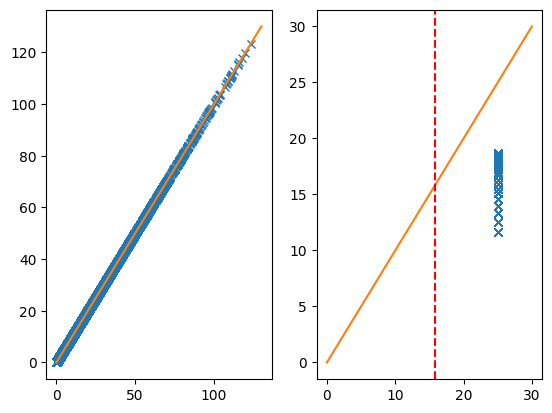

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.795  0.369E+00    31968   135.93  0.531   [Radiance 0.660 micron]
     2  -1.411  0.407E+00    31968   135.93  0.531   [Radiance 0.660 micron]
     3  -1.737  0.417E+00    31968   135.93  0.531   [Radiance 0.660 micron]
     4  -1.966  0.235E+00    32154   136.63  0.534   [Radiance 0.660 micron]
     5  -2.248  0.135E+00    32999   139.36  0.544   [Radiance 0.660 micron]
     6  -2.309  0.806E-01    35253   146.08  0.571   [Radiance 0.660 micron]
     7  -2.439  0.591E-01    38036   153.46  0.599   [Radiance 0.660 micron]
     8  -2.494  0.452E-01    41877   162.05  0.633   [Radiance 0.660 micron]
     9  -2.598  0.378E-01    45803   169.39  0.662   [Radiance 0.660 micron]
    10  -2.669  0.315E-01    50461   176.60  0.690   [Radiance 0.660 micron]
    11  -2.859  0.300E-01    52193   178.95  0.699   [Radiance 0.660 micron]
    12  -3.154  0.300E-01    52269   179.03  0.699   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

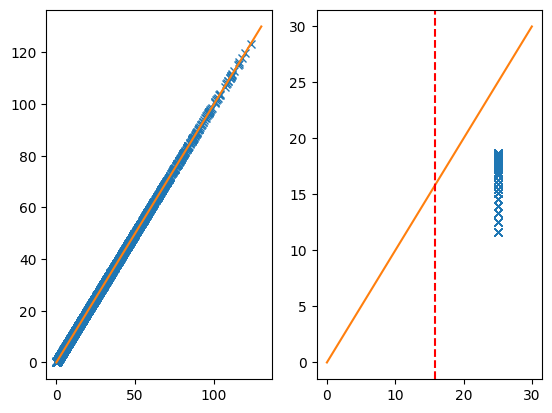

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.823  0.371E+00    31968   130.28  0.509   [Radiance 0.660 micron]
     2  -1.441  0.408E+00    31968   130.28  0.509   [Radiance 0.660 micron]
     3  -1.768  0.418E+00    31968   130.28  0.509   [Radiance 0.660 micron]
     4  -1.995  0.224E+00    32184   131.10  0.512   [Radiance 0.660 micron]
     5  -2.264  0.129E+00    33136   134.28  0.525   [Radiance 0.660 micron]
     6  -2.336  0.777E-01    35545   141.74  0.554   [Radiance 0.660 micron]
     7  -2.469  0.567E-01    38542   149.97  0.586   [Radiance 0.660 micron]
     8  -2.517  0.432E-01    42771   159.55  0.623   [Radiance 0.660 micron]
     9  -2.615  0.362E-01    46848   167.28  0.653   [Radiance 0.660 micron]
    10  -2.704  0.304E-01    51635   174.72  0.683   [Radiance 0.660 micron]
    11  -2.974  0.300E-01    52259   175.58  0.686   [Radiance 0.660 micron]
    12  -3.213  0.300E-01    52302   175.64  0.686   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

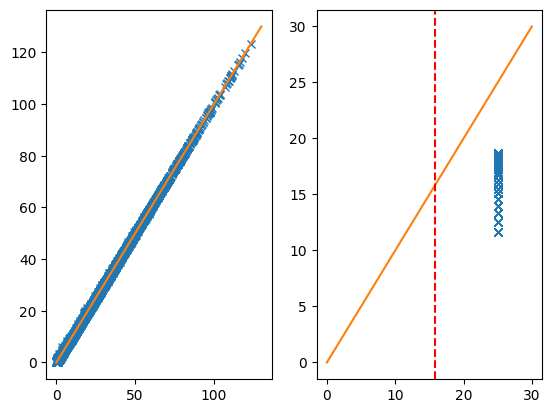

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.811  0.371E+00    31968   130.62  0.510   [Radiance 0.660 micron]
     2  -1.424  0.409E+00    31968   130.62  0.510   [Radiance 0.660 micron]
     3  -1.753  0.419E+00    31968   130.62  0.510   [Radiance 0.660 micron]
     4  -1.982  0.230E+00    32165   131.38  0.513   [Radiance 0.660 micron]
     5  -2.261  0.132E+00    33090   134.49  0.525   [Radiance 0.660 micron]
     6  -2.326  0.789E-01    35461   141.81  0.554   [Radiance 0.660 micron]
     7  -2.456  0.575E-01    38394   149.88  0.585   [Radiance 0.660 micron]
     8  -2.507  0.440E-01    42412   159.03  0.621   [Radiance 0.660 micron]
     9  -2.615  0.368E-01    46465   166.83  0.652   [Radiance 0.660 micron]
    10  -2.686  0.307E-01    51340   174.54  0.682   [Radiance 0.660 micron]
    11  -2.945  0.300E-01    52299   175.86  0.687   [Radiance 0.660 micron]
    12  -3.198  0.300E-01    52367   175.94  0.687   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

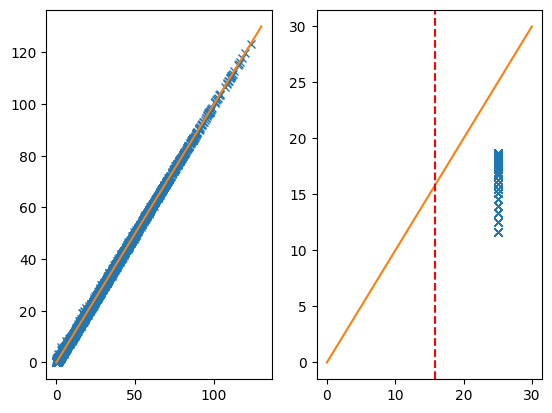

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.795  0.372E+00    31968   103.28  0.403   [Radiance 0.660 micron]
     2  -1.406  0.410E+00    31968   103.28  0.403   [Radiance 0.660 micron]
     3  -1.733  0.420E+00    31968   103.28  0.403   [Radiance 0.660 micron]
     4  -1.963  0.237E+00    32156   104.16  0.407   [Radiance 0.660 micron]
     5  -2.250  0.136E+00    32967   107.53  0.420   [Radiance 0.660 micron]
     6  -2.308  0.809E-01    35260   116.30  0.454   [Radiance 0.660 micron]
     7  -2.438  0.592E-01    38096   125.89  0.492   [Radiance 0.660 micron]
     8  -2.500  0.453E-01    41990   137.02  0.535   [Radiance 0.660 micron]
     9  -2.593  0.376E-01    46023   146.79  0.573   [Radiance 0.660 micron]
    10  -2.672  0.316E-01    50579   155.86  0.609   [Radiance 0.660 micron]
    11  -2.871  0.300E-01    52346   158.99  0.621   [Radiance 0.660 micron]
    12  -3.165  0.300E-01    52419   159.09  0.621   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

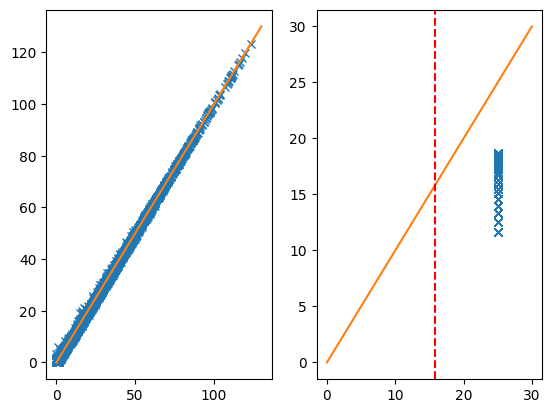

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.782  0.373E+00    31968    99.05  0.387   [Radiance 0.660 micron]
     2  -1.389  0.410E+00    31968    99.05  0.387   [Radiance 0.660 micron]
     3  -1.719  0.420E+00    31968    99.05  0.387   [Radiance 0.660 micron]
     4  -1.951  0.242E+00    32139    99.88  0.390   [Radiance 0.660 micron]
     5  -2.244  0.140E+00    32920   103.23  0.403   [Radiance 0.660 micron]
     6  -2.298  0.822E-01    35162   112.07  0.438   [Radiance 0.660 micron]
     7  -2.430  0.602E-01    37963   121.87  0.476   [Radiance 0.660 micron]
     8  -2.490  0.460E-01    41681   132.94  0.519   [Radiance 0.660 micron]
     9  -2.581  0.382E-01    45716   143.10  0.559   [Radiance 0.660 micron]
    10  -2.668  0.322E-01    50106   152.23  0.595   [Radiance 0.660 micron]
    11  -2.833  0.300E-01    52373   156.43  0.611   [Radiance 0.660 micron]
    12  -3.122  0.300E-01    52467   156.56  0.612   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

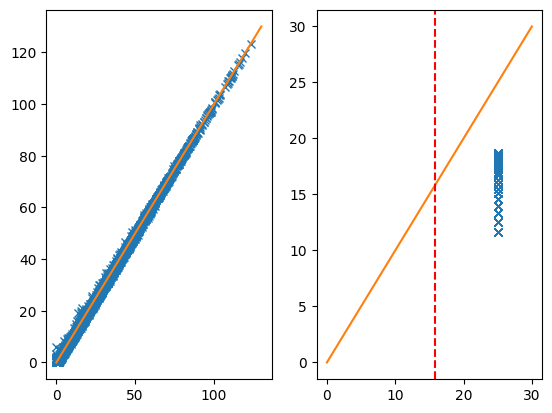

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.773  0.373E+00    31968    87.52  0.342   [Radiance 0.660 micron]
     2  -1.379  0.410E+00    31968    87.52  0.342   [Radiance 0.660 micron]
     3  -1.707  0.420E+00    31968    87.52  0.342   [Radiance 0.660 micron]
     4  -1.938  0.245E+00    32129    88.36  0.345   [Radiance 0.660 micron]
     5  -2.233  0.142E+00    32881    91.85  0.359   [Radiance 0.660 micron]
     6  -2.290  0.838E-01    35018   100.96  0.394   [Radiance 0.660 micron]
     7  -2.419  0.612E-01    37788   111.41  0.435   [Radiance 0.660 micron]
     8  -2.484  0.469E-01    41402   123.12  0.481   [Radiance 0.660 micron]
     9  -2.571  0.388E-01    45489   134.28  0.525   [Radiance 0.660 micron]
    10  -2.653  0.327E-01    49818   144.05  0.563   [Radiance 0.660 micron]
    11  -2.804  0.300E-01    52468   149.28  0.583   [Radiance 0.660 micron]
    12  -3.106  0.300E-01    52591   149.49  0.584   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

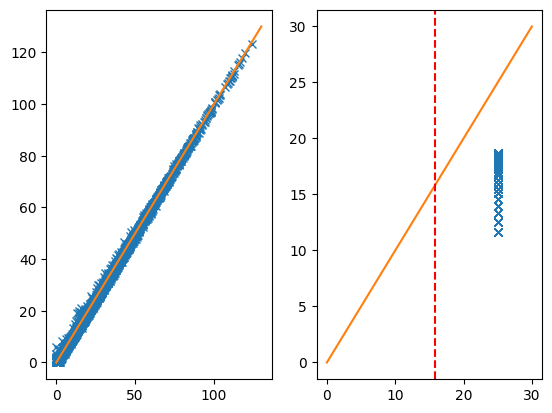

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.766  0.373E+00    31968    89.39  0.349   [Radiance 0.660 micron]
     2  -1.372  0.410E+00    31968    89.39  0.349   [Radiance 0.660 micron]
     3  -1.700  0.420E+00    31968    89.39  0.349   [Radiance 0.660 micron]
     4  -1.932  0.249E+00    32127    90.21  0.352   [Radiance 0.660 micron]
     5  -2.227  0.144E+00    32857    93.52  0.365   [Radiance 0.660 micron]
     6  -2.281  0.846E-01    34963   102.42  0.400   [Radiance 0.660 micron]
     7  -2.419  0.620E-01    37656   112.51  0.440   [Radiance 0.660 micron]
     8  -2.470  0.472E-01    41340   124.30  0.486   [Radiance 0.660 micron]
     9  -2.573  0.394E-01    45159   134.77  0.526   [Radiance 0.660 micron]
    10  -2.638  0.329E-01    49743   145.16  0.567   [Radiance 0.660 micron]
    11  -2.795  0.300E-01    52583   150.66  0.589   [Radiance 0.660 micron]
    12  -3.094  0.300E-01    52707   150.86  0.589   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

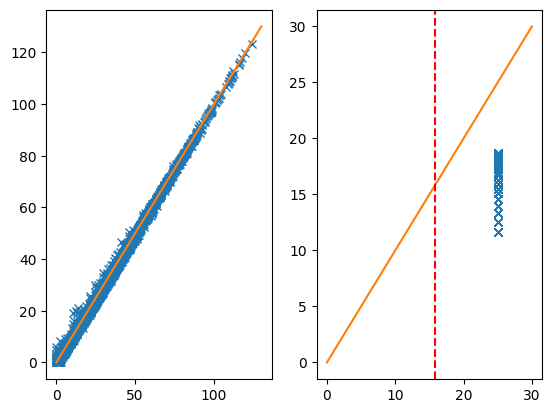

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.766  0.373E+00    31968    96.54  0.377   [Radiance 0.660 micron]
     2  -1.372  0.411E+00    31968    96.54  0.377   [Radiance 0.660 micron]
     3  -1.699  0.421E+00    31968    96.54  0.377   [Radiance 0.660 micron]
     4  -1.931  0.249E+00    32127    97.32  0.380   [Radiance 0.660 micron]
     5  -2.225  0.144E+00    32861   100.50  0.393   [Radiance 0.660 micron]
     6  -2.280  0.849E-01    34942   108.97  0.426   [Radiance 0.660 micron]
     7  -2.416  0.621E-01    37678   118.81  0.464   [Radiance 0.660 micron]
     8  -2.466  0.473E-01    41359   130.08  0.508   [Radiance 0.660 micron]
     9  -2.578  0.396E-01    45153   140.02  0.547   [Radiance 0.660 micron]
    10  -2.638  0.329E-01    49872   150.28  0.587   [Radiance 0.660 micron]
    11  -2.790  0.300E-01    52653   155.43  0.607   [Radiance 0.660 micron]
    12  -3.094  0.300E-01    52783   155.63  0.608   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

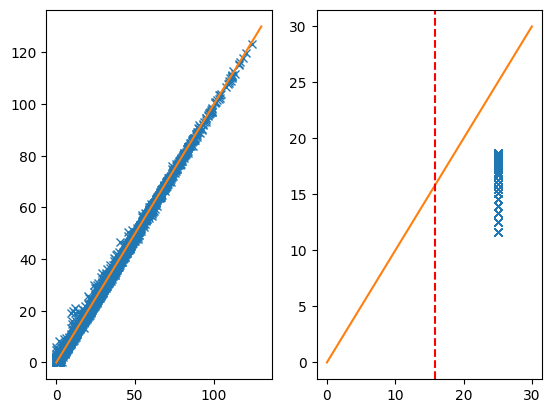

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.767  0.374E+00    31968   101.20  0.395   [Radiance 0.660 micron]
     2  -1.375  0.411E+00    31968   101.20  0.395   [Radiance 0.660 micron]
     3  -1.702  0.421E+00    31968   101.20  0.395   [Radiance 0.660 micron]
     4  -1.933  0.249E+00    32131   101.98  0.398   [Radiance 0.660 micron]
     5  -2.225  0.143E+00    32890   105.17  0.411   [Radiance 0.660 micron]
     6  -2.281  0.847E-01    34977   113.42  0.443   [Radiance 0.660 micron]
     7  -2.415  0.620E-01    37718   123.02  0.481   [Radiance 0.660 micron]
     8  -2.465  0.473E-01    41443   134.12  0.524   [Radiance 0.660 micron]
     9  -2.586  0.396E-01    45238   143.75  0.562   [Radiance 0.660 micron]
    10  -2.633  0.327E-01    50102   153.94  0.601   [Radiance 0.660 micron]
    11  -2.799  0.300E-01    52780   158.73  0.620   [Radiance 0.660 micron]
    12  -3.092  0.300E-01    52893   158.90  0.621   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

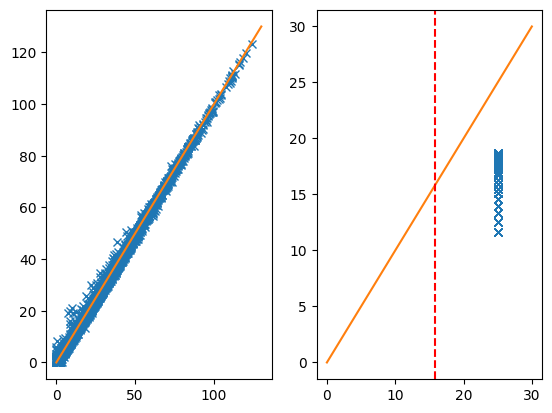


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350     10     11   9598     0 15258   1.616D-02   1.138D+01
  F =   11.380820644792399     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [10]:
# add an uncertainty model to the observations.
uncertainty = at3d.uncertainties.NullUncertainty('L2',1e8)#at3d.uncertainties.TandemStereoCamera('L2', camera_to_camera_calibration_uncertainty=0.0,
              #                                      absolute_calibration_uncertainty=0.0)#at3d.uncertainties.RadiometricUncertainty('L2',1e-5, 1e-3)
sensors.add_uncertainty_model('MSPI', uncertainty)

grid_to_optical_properties._fixed_dataset["reff"] = solvers[0.66].medium['cloud'].reff*0 + 25
unknown_scatterers = at3d.containers.UnknownScatterers(
    at3d.medium.UnknownScatterer(grid_to_optical_properties,
    density=(None, at3d.transforms.StateToGridMask(mask=carved_volume.mask.data)))
)
# now we form state_gen which updates the solvers with an input_state.

state_gen = at3d.medium.StateGenerator(solvers_reconstruct,
                                        unknown_scatterers, surfaces,
                                        numerical_parameters, sources, background_optical_scatterers,
                                        num_stokes)
# get bounds automatically.
min_bounds, max_bounds = state_gen.transform_bounds()

warnings.filterwarnings('ignore')
initial_gridded_extinction = 3.0*solvers[0.66].medium['cloud'].density.data/(2.0*997.0* solvers[0.66].medium['cloud'].reff.data*1e-6)
initial_1d_extinction = state_gen._unknown_scatterers['cloud'].variables['density'].state_to_grid.inverse_transform(initial_gridded_extinction)
x0 = state_gen._unknown_scatterers['cloud'].variables['density'].coordinate_transform.inverse_transform(initial_1d_extinction)
objective_function = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
        sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, state_gen,
        state_gen.project_gradient_to_state,
            parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
        gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
        uncertainty_kwargs={'add_noise': False},
        min_bounds=min_bounds, max_bounds=max_bounds)

optimizer = at3d.optimize.Optimizer(objective_function,callback_fn=callback, options={'maxiter': 30, 'maxls': 10, 'disp': True, 'gtol': 1e-16, 'ftol': 1e-8})

optimizer._options['maxiter'] = 10
result = optimizer.minimize(x0)